In [35]:
import scanpy as sc
import pandas as pd
import pickle
import scarches as sca
import datetime
import os
import argparse
import glob
import anndata as ann
import numpy as np
import argparse
import datetime
import json
import warnings
import anndata
from scipy import sparse

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# Path to data used for integration
path_ref='/lustre/groups/ml01/workspace/karin.hrovatin//data/pancreas/scRNA/combined/data_integrated_annotated.h5ad'
path_query='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE137909/GEO/adata.h5ad'
model_dir='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/scArches/integrate_combine_individual/run_scArches1603792372.695119/'
query_study='GSE137909'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin//data/pancreas/gene_lists/'

## Prepare data

### Reference

In [3]:
# Load parameters of ref model
params=pickle.load(open(model_dir+'params.pkl','rb'))
print('Old params:',params)

Old params: {'z_dimension': 15, 'architecture': [128, 128, 128], 'task_name': 'run_scArches1603792372.695119', 'x_dimension': 2000, 'beta': 0.0, 'alpha': 0.99, 'loss_fn': 'sse', 'n_epochs': 150, 'batch_size': 128, 'subset_beta': False, 'hvg_n': '2000', 'input_file_name': 'data_normlisedForIntegration.h5ad'}


In [4]:
# Change params for new networks
params_new=params.copy()
params_new['task_name']='mapref_scArches'+str(datetime.datetime.now().timestamp())
params_new['task_name_atlas']=params['task_name']
params_new['sca_version']='scArches'
print('New params',params_new)

New params {'z_dimension': 15, 'architecture': [128, 128, 128], 'task_name': 'mapref_scArches1654194426.493706', 'x_dimension': 2000, 'beta': 0.0, 'alpha': 0.99, 'loss_fn': 'sse', 'n_epochs': 150, 'batch_size': 128, 'subset_beta': False, 'hvg_n': '2000', 'input_file_name': 'data_normlisedForIntegration.h5ad', 'task_name_atlas': 'run_scArches1603792372.695119', 'sca_version': 'scArches'}


In [5]:
# *** Reference adata
adata_ref=sc.read(path_ref)

In [6]:
# Genes used for atlas creation
used_genes=json.load(open(model_dir+'scArches.json','r'))['gene_names']
# Subset ref
eid_map=dict(zip(adata_ref.var.gene_symbol_original_matched,adata_ref.var_names))
used_eids=[eid_map[g] for g in used_genes]
adata_ref=adata_ref[:,used_eids]

In [7]:
# Ensure that adata.raw.X (used by scArches in nb) has the same genes as adata.X
adata_ref.raw=adata_ref.raw[:,adata_ref.raw.var_names.isin(adata_ref.var_names)].to_adata()
# Rename size factors so that scArches finds them
if 'size_factors' in adata_ref.obs.columns:
    print('Size factors are already present - renaming them to size_factors_old')
adata_ref.obs.rename(columns={'size_factors': 'size_factors_old', 'size_factors_sample': 'size_factors'}, inplace=True)

### Query

In [16]:
#Load query data
adata_pp=sc.read(path_query)

In [17]:
# Remap new query data to integration genes
vals=[]
rows=[]
cols=[]
eid_mm_map=dict(zip(adata_ref.var_names,range(adata_ref.shape[1])))
for row,eid_mm in enumerate(adata_pp.var_names):
    if eid_mm in eid_mm_map:
        col=eid_mm_map[eid_mm]
        vals.append(1)
        rows.append(row)
        cols.append(col)
gene_inetgration_map=sparse.csr_matrix(
    (np.array(vals), (np.array(rows), np.array(cols))), 
    shape=(adata_pp.shape[1], adata_ref.shape[1]))

In [18]:
# Subset raw query data
adata_query=sc.AnnData(
    sparse.csr_matrix(adata_pp.layers['raw'])@gene_inetgration_map,
    obs=adata_pp.obs,
    var=adata_ref.var[['gene_symbol', 'used_integration', 'gene_symbol_original_matched']])
# Make raw
adata_query.raw=adata_query.copy()
# Normalise raw data with previously compited size factors
adata_query.X /= adata_query.obs['size_factors_sample'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata_query)
adata_query.X = np.asarray(adata_query.X)
print('Integration data shape:',adata_query.shape) 

Integration data shape: (2999, 2000)


In [19]:
# Rename size factors so that scArches finds them
if 'size_factors' in adata_query.obs.columns:
    print('Size factors are already present - renaming them to size_factors_old')
else:
    adata_query.obs.rename(columns={'size_factors': 'size_factors_old', 'size_factors_sample': 'size_factors'}, inplace=True)

In [20]:
print('Reference adata')
print(adata_ref.shape)
print('Query adata')
print(adata_query.shape)

Reference adata
(301796, 2000)
Query adata
(2999, 2000)


## Reference mapping

Restore model

In [21]:
# *** Restore model
network = sca.models.scArches(task_name=params['task_name'],
    x_dimension=params['x_dimension'],
    z_dimension=params['z_dimension'],
    architecture=params['architecture'],
    gene_names=adata_ref.var_names.tolist(),
    conditions=adata_ref.obs['study_sample'].unique().tolist(),
    alpha=params['alpha'], 
    beta=params['beta'],
    loss_fn=params['loss_fn'],
    # Strip task name from model dir as this is appended within network
    model_path='/'.join(model_dir.split('/')[:-2])+'/', 
    )






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
scArches' network has been successfully constructed!

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scArches' network has been successfully compiled!


In [22]:
# Make sure that model exists before training (if model exists training will just reload)
if not os.path.exists(os.path.join(network.model_path, f"{network.model_name}.h5")):
    raise ValueError('Model path not found:',
                     os.path.join(network.model_path, f"{network.model_name}.h5"))

In [23]:
# reload model params
network.train(adata_ref,
              condition_key='study_sample',
              retrain=False,
              # These conditions are not really needed as network is not retrained
              n_epochs=params['n_epochs'],
              batch_size=params['batch_size'],
              save=False
             )

scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


Modify scArches model with new batches

In [24]:
# overwrittes, just naming
network_new=network

In [ ]:
# new conditions not present in ref
new_conditions=adata_query.obs['donor'].unique().tolist()

Re-train model for the query

In [25]:
# path save
path_save='/'.join(path_query.split('/')[:-1])+'/'+network_new.task_name+'/'
#path_save='/'.join(path_query.split('/')[:-1])+'/'+params_new['task_name']+'/'

In [26]:
# Make query mapping model
network_new = sca.operate(
    network_new,
    new_task_name=params_new['task_name'],
    new_conditions=new_conditions,
    # Does not work, so change below
    #new_network_kwargs={'model_path':path_out}
    # Mo's suggestion
    #new_network_kwargs={'use_batchnorm':params_new['use_batchnorm']},
    version=params_new['sca_version']
                     )
network_new.model_path=path_save
network_new.train(adata_query,
          condition_key='donor',
          retrain=True,
          n_epochs=params_new['n_epochs'],
          batch_size=params_new['batch_size'],
          save=True,
          #early_stop_limit=params_new['early_stop']
         )   

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
 |█████████-----------| 47.3%  - loss: 80.4731 - mmd_loss: 0.0000 - recon_loss: 80.4731 - val_loss: 568.3679 - val_mmd_loss: 0.0000 - val_recon_loss: 568.3679Training stopped with Early Stopping

scArches has been successfully saved in /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE137909/GEO/run_scArches1603792372.695119/.


Get query latent representation

In [27]:
# get query latent rep
latent_query = network_new.get_latent(adata_query, 'donor')
latent_query.obs_names=[obs+'-'+query_study for obs in latent_query.obs_names]

#### Save latent query

In [69]:
# Save query prediction
latent_query.write(path_save+'latent_query.h5ad')

### Compare embeddings in query and ref

In [44]:
# Sanity check joint embedding
# Extract embedding and metadata from ref and query
x_temp=pd.concat([latent_query.to_df(),
                 pd.DataFrame(adata_ref.obsm['X_integrated'], index=adata_ref.obs_names,
                              columns=[str(i) for i in 
                                       range(adata_ref.obsm['X_integrated'].shape[1])])])
x_temp.loc[[c+'-'+query_study for c in adata_query.obs_names],
           'cell_type']=adata_query.obs['cell_type'].values
x_temp.loc[adata_ref.obs_names,'cell_type']=adata_ref.obs.cell_type.values
x_temp.loc[adata_ref.obs_names,'study']=adata_ref.obs.study.values
x_temp['study'].fillna(query_study,inplace=True)
x_temp.loc[adata_ref.obs_names,'set']='ref'
x_temp['set'].fillna('query',inplace=True)

In [45]:
# Make umap on data subset
# Subset ref and query, excluded NA ct cells for now just to have ct labels
obs_names=[]
random_indices=np.random.permutation(list(range(latent_query.shape[0])))[:10000]
obs_names.extend(latent_query.obs_names[random_indices])
random_indices=np.random.permutation(list(range(adata_ref.shape[0])))
random_indices=adata_ref.obs_names[random_indices]
random_indices=[i for i in random_indices if i in x_temp.index][:20000]
obs_names.extend(random_indices)
random_indices_ref=random_indices
# Adata
dims=[str(i) for i in range(adata_ref.obsm['X_integrated'].shape[1])]
adata_temp=sc.AnnData(x_temp.loc[obs_names,dims],
                      obs=x_temp.loc[obs_names,[c for c in x_temp if c not in dims]])

In [46]:
# Make joint umap
sc.pp.neighbors(adata_temp)
sc.tl.umap(adata_temp)

In [66]:
# Add ref diabetes info
adata_ref.obs['diabetes']=adata_ref.obs.study_sample_design.map({
 'NOD_elimination_SRR7610298_14w':'T1D',
 'NOD_elimination_SRR7610299_14w':'T1D',
 'NOD_elimination_SRR7610300_14w':'T1D',
 'NOD_elimination_SRR7610301_16w':'T1D',
 'NOD_elimination_SRR7610302_16w':'T1D',
 'NOD_elimination_SRR7610303_16w':'T1D',
 'STZ_G2_STZ':'T2D',
 'STZ_G3_STZ_insulin':'T2D',
 'STZ_G4_STZ_GLP-1':'T2D',
 'STZ_G5_STZ_estrogen':'T2D',
 'STZ_G6_STZ_GLP-1_estrogen':'T2D',
 'STZ_G8_STZ_GLP-1_estrogen+insulin':'T2D',
 'VSG_MUC13631_PF_Lepr-/-':'T2D',
 'VSG_MUC13632_PF_Lepr-/-':'T2D',
 'VSG_MUC13639_sham_Lepr-/-':'T2D',
 'VSG_MUC13640_VSG_Lepr-/-':'T2D',
 'VSG_MUC13641_sham_Lepr-/-':'T2D',
 'VSG_MUC13642_VSG_Lepr-/-':'T2D'}).fillna('non-diabetic')
cells=[c for c in adata_temp.obs_names if c in adata_ref.obs_names]
adata_temp.obs.loc[cells,'diabetes']=adata_ref.obs.loc[cells,'diabetes']

# Add query STZ and age
cells=[c for c in adata_temp.obs_names if c.replace('-'+query_study,'') in adata_query.obs_names]
cells_query=[c.replace('-'+query_study,'') for c in cells]
adata_temp.obs.loc[cells,'STZ']=adata_query.obs.loc[cells_query,'STZ'].values
adata_temp.obs.loc[cells,'age']=adata_query.obs.loc[cells_query,'age'].values

... storing 'STZ' as categorical
... storing 'age' as categorical


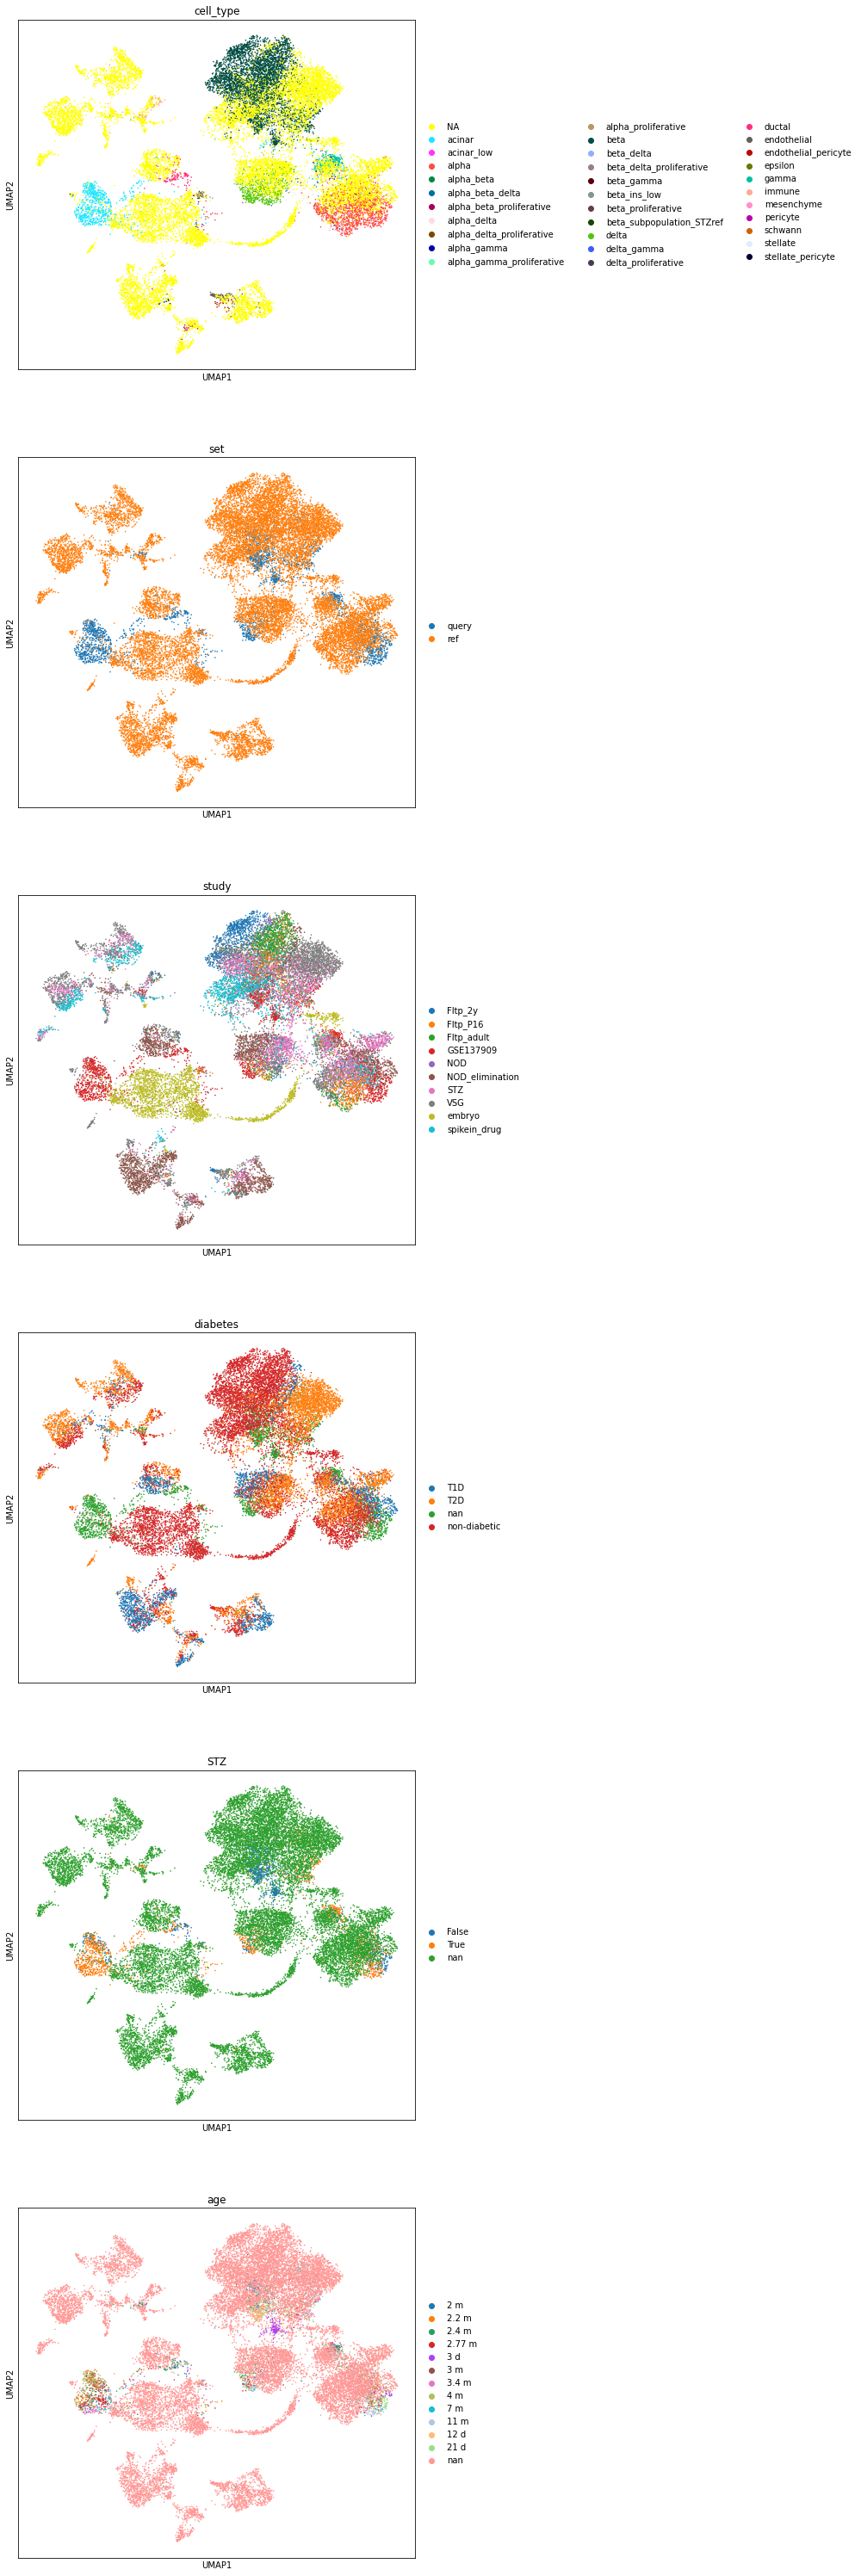

In [67]:
# Plot ct and ref/query
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata_temp,color=['cell_type','set','study','diabetes','STZ','age'],ncols=1,s=10)